# House Price Prediction


**Table of contents**<a id='toc0_'></a>

- 1. [Data Preparation](#toc1_)
  - 1.1. [Data Collection & Ingestion](#toc1_1_)
  - 1.2. [Data Cleaning](#toc1_2_)
- 2. [Exploratory Data Analysis](#toc2_)
  - 2.1. [Univariate Analysis](#toc2_1_)
    - 2.1.1. [Numerical Columns](#toc2_1_1_)
    - 2.1.2. [Binary columns](#toc2_1_2_)
    - 2.1.3. [Categorical columns](#toc2_1_3_)
  - 2.2. [Bivariate/Multivariate Analysis](#toc2_2_)
    - 2.2.1. [Numerical values](#toc2_2_1_)
- 3. [Feature Engineering](#toc3_)
  - 3.1. [Transformations & Encoding](#toc3_1_)
    - 3.1.1. [Handling skewness in numerical columns](#toc3_1_1_)
    - 3.1.2. [Numerical values standardization](#toc3_1_2_)
    - 3.1.3. [Convert boolean columns to 0/1 encoding](#toc3_1_3_)
    - 3.1.4. [One-hot encoding for categorical values](#toc3_1_4_)
- 4. [Modeling Approaches](#toc4_)
  - 4.1. [Data preparation for modelling](#toc4_1_)
  - 4.2. [Traditional and Gradient Boosting Models Machine Learning Models](#toc4_2_)
  - 4.3. [Neural Network approach](#toc4_3_)
- 5. [Models comparison](#toc5_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


In [261]:
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 1. <a id='toc1_'></a>[Data Preparation](#toc0_)


### 1.1. <a id='toc1_1_'></a>[Data Collection & Ingestion](#toc0_)


In [262]:
dataset = pd.read_csv("./data/Housing.csv")
dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [263]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [264]:
dataset.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


### 1.2. <a id='toc1_2_'></a>[Data Cleaning](#toc0_)


In [265]:
dataset.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [266]:
dataset.duplicated().sum()

np.int64(0)

## 2. <a id='toc2_'></a>[Exploratory Data Analysis](#toc0_)


### 2.1. <a id='toc2_1_'></a>[Univariate Analysis](#toc0_)


#### 2.1.1. <a id='toc2_1_1_'></a>[Numerical Columns](#toc0_)


In [267]:
numerical_columns = ["price", "area"]

Skwness of price feature: 1.2122388370279802


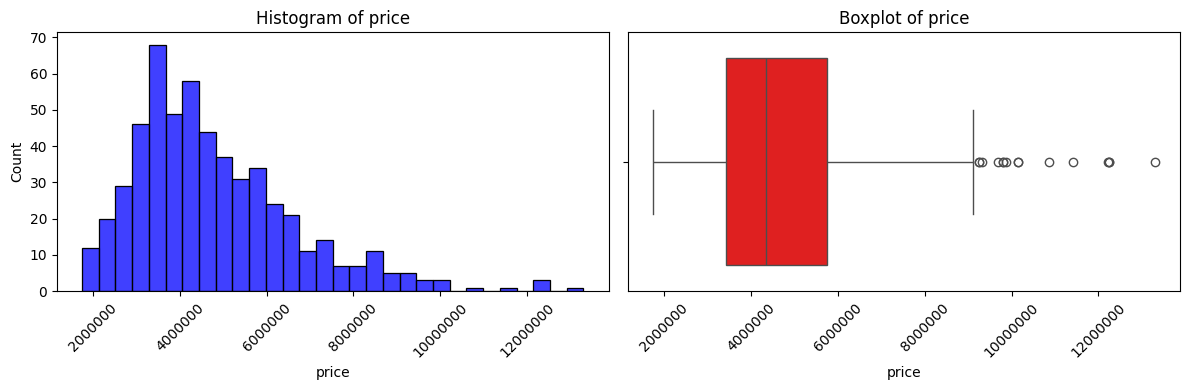

Skwness of area feature: 1.321188343153483


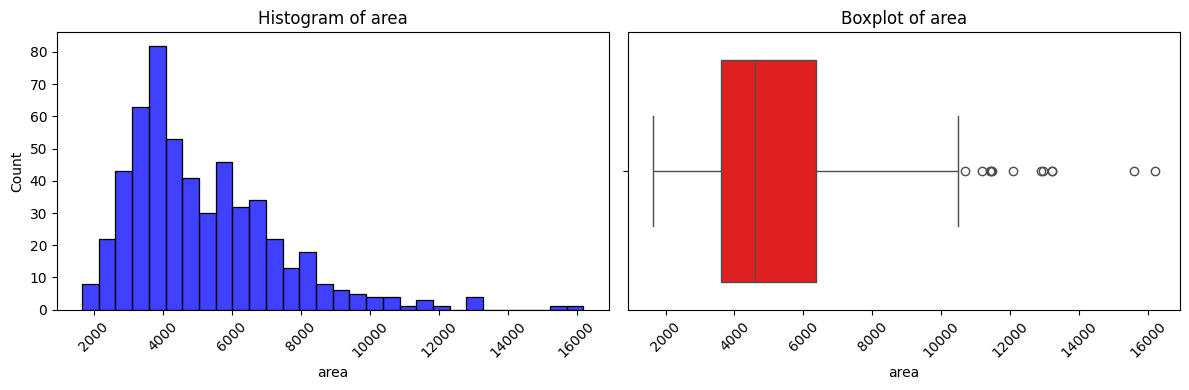

In [268]:
def plot_numerical_columns(dataset: pd.DataFrame, numerical_columns: List[str]) -> None:
    for col in numerical_columns:
        _, axes = plt.subplots(1, 2, figsize=(12, 4))
        skewness = dataset[col].skew()
        print(f"Skwness of {col} feature: {skewness}")

        sns.histplot(dataset[col], bins=30, ax=axes[0], color="blue")
        axes[0].set_title(f"Histogram of {col}")
        axes[0].ticklabel_format(style="plain")
        axes[0].tick_params(axis="x", rotation=45)

        sns.boxplot(x=dataset[col], ax=axes[1], color="red")
        axes[1].set_title(f"Boxplot of {col}")
        axes[1].xaxis.set_major_formatter(ScalarFormatter())
        axes[1].tick_params(axis="x", rotation=45)
        axes[1].ticklabel_format(style="plain", axis="x")
        axes[1].xaxis.get_offset_text().set_visible(False)

        plt.tight_layout()
        plt.show()


plot_numerical_columns(dataset, numerical_columns)

#### 2.1.2. <a id='toc2_1_2_'></a>[Binary columns](#toc0_)


In [269]:
binary_columns = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea",
]

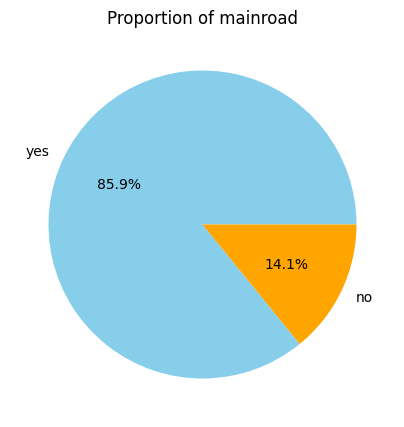

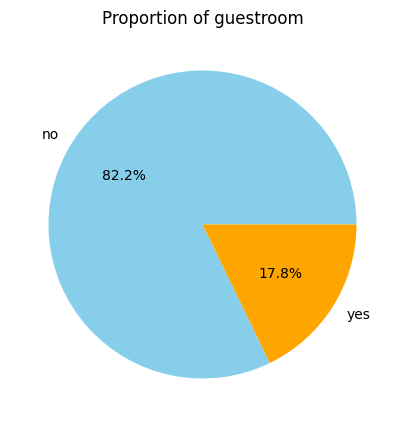

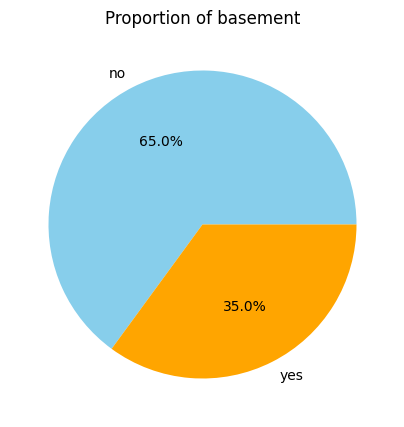

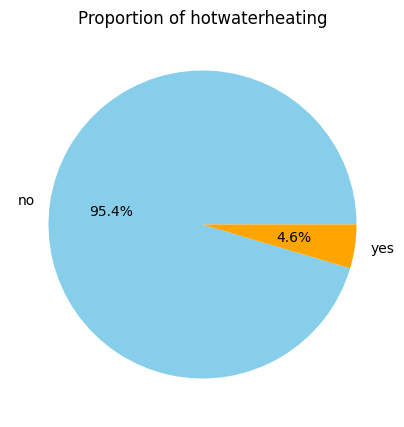

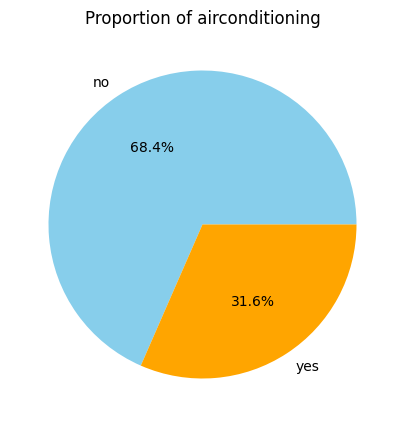

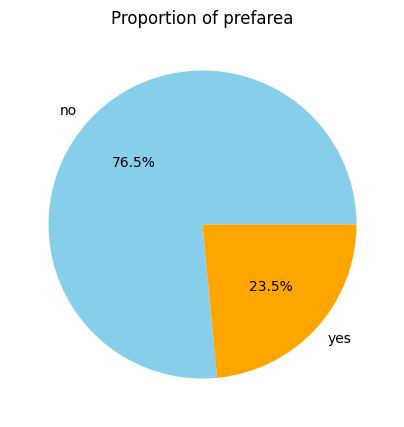

In [270]:
def plot_binary_columns(dataset: pd.DataFrame, binary_columns: List[str]) -> None:
    for col in binary_columns:
        plt.figure(figsize=(5, 5))
        dataset[col].value_counts().plot.pie(
            autopct="%1.1f%%", colors=["skyblue", "orange"]
        )
        plt.title(f"Proportion of {col}")
        plt.ylabel("")
        plt.show()


plot_binary_columns(dataset, binary_columns)

#### 2.1.3. <a id='toc2_1_3_'></a>[Categorical columns](#toc0_)


In [271]:
categorical_columns = [
    "bedrooms",
    "bathrooms",
    "stories",
    "parking",
    "furnishingstatus",
]

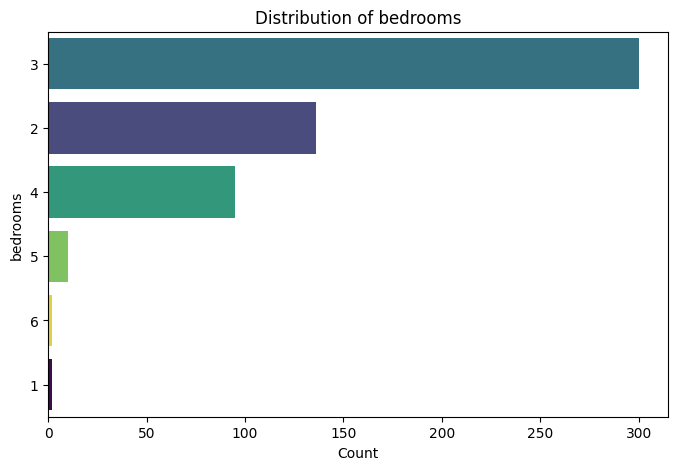

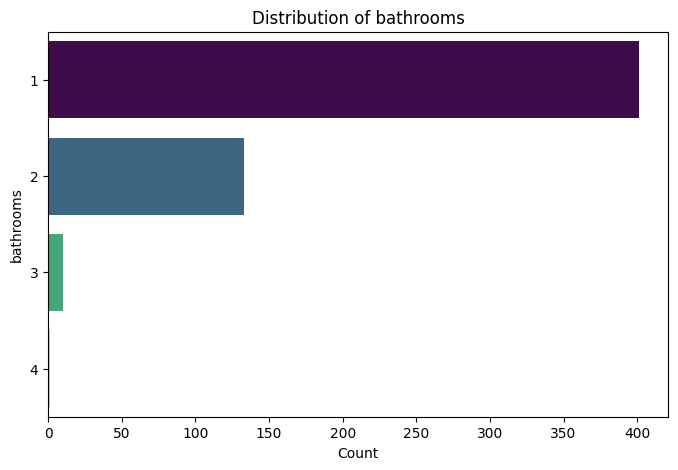

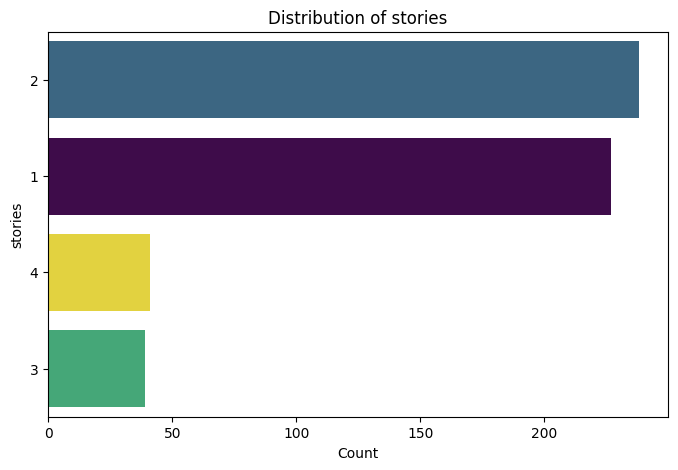

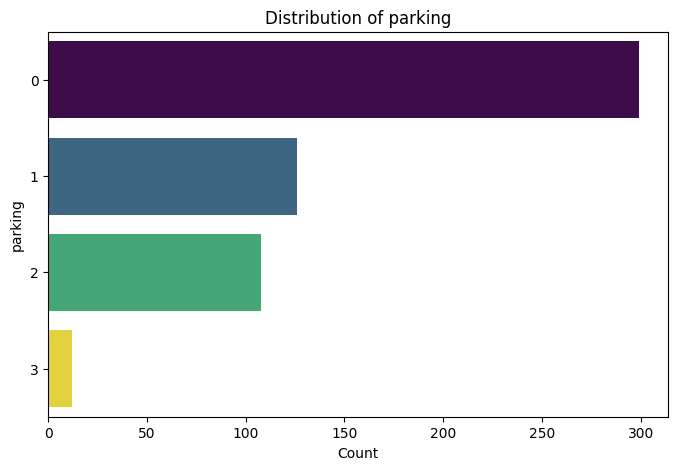

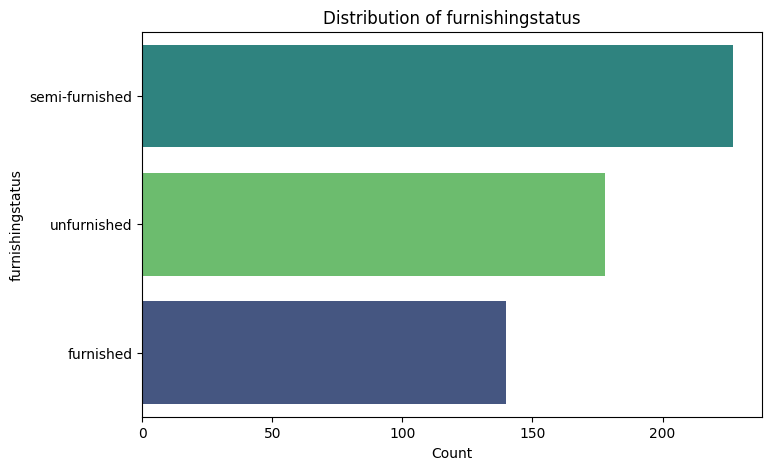

In [272]:
def plot_categorical_columns(
    dataset: pd.DataFrame, categorical_columns: List[str]
) -> None:
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(
            y=dataset[col],
            hue=dataset[col],
            legend=False,
            order=dataset[col].value_counts().index,
            palette="viridis",
        )
        plt.title(f"Distribution of {col}")
        plt.xlabel("Count")
        plt.ylabel(col)
        plt.show()


plot_categorical_columns(dataset, categorical_columns)

### 2.2. <a id='toc2_2_'></a>[Bivariate/Multivariate Analysis](#toc0_)


#### 2.2.1. <a id='toc2_2_1_'></a>[Numerical values](#toc0_)


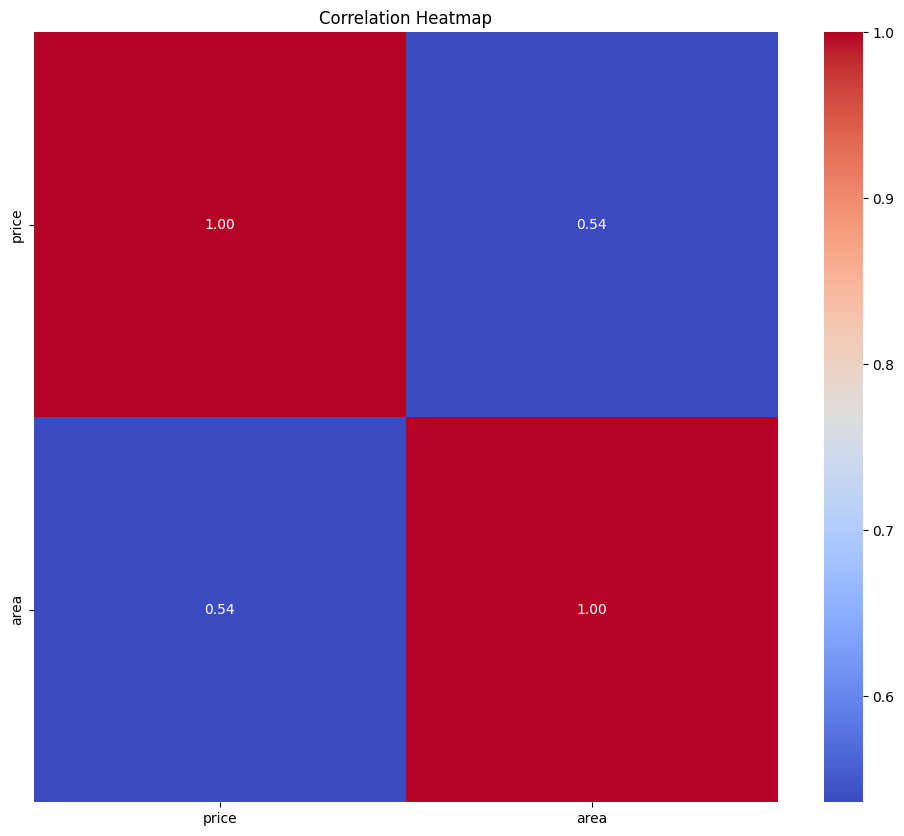

In [273]:
numerical_columns_dataset = dataset[numerical_columns].copy()

plt.figure(figsize=(12, 10))
sns.heatmap(numerical_columns_dataset.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

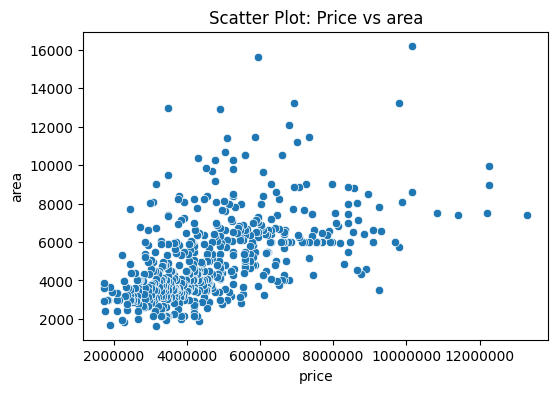

In [274]:
for col in numerical_columns_dataset.columns:
    if col != "price":
        plt.figure(figsize=(6, 4))
        plt.ticklabel_format(style="plain")
        sns.scatterplot(
            x=numerical_columns_dataset["price"],
            y=numerical_columns_dataset[col],
        )
        plt.title(f"Scatter Plot: Price vs {col}")
        plt.show()

## 3. <a id='toc3_'></a>[Feature Engineering](#toc0_)


### 3.1. <a id='toc3_1_'></a>[Transformations & Encoding](#toc0_)


#### 3.1.2. <a id='toc3_1_2_'></a>[Numerical values standardization](#toc0_)


In [275]:
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,4.566365,1.046726,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,4.004484,1.757010,4,4,4,yes,no,no,no,yes,3,no,furnished
2,4.004484,2.218232,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,3.985755,1.083624,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,3.554979,1.046726,4,1,2,yes,yes,yes,no,yes,2,no,furnished


#### 3.1.3. <a id='toc3_1_3_'></a>[Convert boolean columns to 0/1 encoding](#toc0_)


In [276]:
for col in binary_columns:
    dataset[col] = dataset[col].map({"yes": 1, "no": 0})

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,4.566365,1.046726,4,2,3,1,0,0,0,1,2,1,furnished
1,4.004484,1.757010,4,4,4,1,0,0,0,1,3,0,furnished
2,4.004484,2.218232,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,3.985755,1.083624,4,2,2,1,0,1,0,1,3,1,furnished
4,3.554979,1.046726,4,1,2,1,1,1,0,1,2,0,furnished


#### 3.1.4. <a id='toc3_1_4_'></a>[One-hot encoding for categorical values](#toc0_)


In [277]:
def one_hot_encode(
    dataset: pd.DataFrame, categorical_columns: List[str]
) -> pd.DataFrame:
    dataset = pd.get_dummies(dataset, columns=categorical_columns, dtype=int)

    return dataset


dataset = one_hot_encode(dataset, categorical_columns)

dataset.head()

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,bedrooms_1,bedrooms_2,...,stories_2,stories_3,stories_4,parking_0,parking_1,parking_2,parking_3,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,4.566365,1.046726,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,4.004484,1.757010,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,4.004484,2.218232,1,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
3,3.985755,1.083624,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
4,3.554979,1.046726,1,1,1,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [278]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            545 non-null    float64
 1   area                             545 non-null    float64
 2   mainroad                         545 non-null    int64  
 3   guestroom                        545 non-null    int64  
 4   basement                         545 non-null    int64  
 5   hotwaterheating                  545 non-null    int64  
 6   airconditioning                  545 non-null    int64  
 7   prefarea                         545 non-null    int64  
 8   bedrooms_1                       545 non-null    int64  
 9   bedrooms_2                       545 non-null    int64  
 10  bedrooms_3                       545 non-null    int64  
 11  bedrooms_4                       545 non-null    int64  
 12  bedrooms_5            

## 4. <a id='toc4_'></a>[Modeling Approaches](#toc0_)


In [279]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

### 4.1. <a id='toc4_1_'></a>[Data preparation for modelling](#toc0_)


In [280]:
def split_data(
    X: pd.DataFrame, y: pd.Series
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test


X = dataset.drop(columns=["price"])
y = dataset["price"]

X_train, X_test, y_train, y_test = split_data(X, y)

### 4.2. <a id='toc4_2_'></a>[Traditional and Gradient Boosting Models Machine Learning Models](#toc0_)


In [281]:
def train_models(
    X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series
) -> Dict[str, Dict[str, float]]:
    results = {}

    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    }

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results[model_name] = evaluate_model(y_test, y_pred)

    return results

### 4.3. <a id='toc4_3_'></a>[Neural Network approach](#toc0_)


In [282]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim: int):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.model(x)
        return x


def train_neural_network(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    epochs: int = 200,
    batch_size: int = 64,
):
    print("Training Neural Network...")

    X_train_np = X_train.to_numpy()
    y_train_np = y_train.to_numpy().reshape(-1, 1)
    X_test_np = X_test.to_numpy()
    y_test_np = y_test.to_numpy().reshape(-1, 1)

    device = "cpu"

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    input_dim = X_train.shape[1]
    model = NeuralNetwork(input_dim=input_dim).to(device)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float("inf")
    patience = 5
    counter = 0

    model.train()

    for epoch in range(epochs):
        print(f"Epoch [{epoch + 1}/{epochs}]")
        total_loss = 0

        for batch_X, batch_y in tqdm(train_loader):
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                y_test_pred = model(batch_X)
                val_loss += loss_fn(y_test_pred, batch_y).item()

        print(
            f"Train Loss = {total_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}"
        )

        if val_loss < best_val_loss - 0.0001:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(
                    f"Early stopping triggered at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}"
                )
                break

    print("Neural Network Training Completed")
    model.eval()

    print("Starting final predictions...")
    torch.cuda.empty_cache()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred = y_pred.detach().cpu().numpy().flatten()

    nn_results = evaluate_model(y_test, y_pred)

    return nn_results

In [283]:
model_results = train_models(X_train, X_test, y_train, y_test)

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...


In [284]:
nn_results = train_neural_network(X_train, X_test, y_train, y_test)

Training Neural Network...
Epoch [1/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.8922, Val Loss = 1.5164
Epoch [2/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.8381, Val Loss = 1.4385
Epoch [3/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.7763, Val Loss = 1.3398
Epoch [4/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.6977, Val Loss = 1.2142
Epoch [5/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.6010, Val Loss = 1.0590
Epoch [6/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.4923, Val Loss = 0.8815
Epoch [7/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.3951, Val Loss = 0.7220
Epoch [8/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.3407, Val Loss = 0.6220
Epoch [9/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.3248, Val Loss = 0.5787
Epoch [10/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.3143, Val Loss = 0.5668
Epoch [11/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.3010, Val Loss = 0.5675
Epoch [12/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2918, Val Loss = 0.5683
Epoch [13/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2845, Val Loss = 0.5619
Epoch [14/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2777, Val Loss = 0.5538
Epoch [15/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2712, Val Loss = 0.5472
Epoch [16/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2654, Val Loss = 0.5437
Epoch [17/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2599, Val Loss = 0.5425
Epoch [18/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2544, Val Loss = 0.5411
Epoch [19/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2495, Val Loss = 0.5400
Epoch [20/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2446, Val Loss = 0.5380
Epoch [21/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2399, Val Loss = 0.5368
Epoch [22/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2355, Val Loss = 0.5361
Epoch [23/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2310, Val Loss = 0.5344
Epoch [24/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2269, Val Loss = 0.5338
Epoch [25/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2227, Val Loss = 0.5320
Epoch [26/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2190, Val Loss = 0.5317
Epoch [27/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2153, Val Loss = 0.5306
Epoch [28/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2121, Val Loss = 0.5305
Epoch [29/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2083, Val Loss = 0.5288
Epoch [30/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2052, Val Loss = 0.5289
Epoch [31/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.2017, Val Loss = 0.5272
Epoch [32/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.1984, Val Loss = 0.5278
Epoch [33/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.1952, Val Loss = 0.5281
Epoch [34/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.1918, Val Loss = 0.5281
Epoch [35/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.1886, Val Loss = 0.5283
Epoch [36/200]


  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss = 0.1855, Val Loss = 0.5283
Early stopping triggered at epoch 36. Best Validation Loss: 1.0544
Neural Network Training Completed
Starting final predictions...


## 5. <a id='toc5_'></a>[Models comparison](#toc0_)


In [285]:
all_results = {"Traditional Models": model_results, "Neural Network": nn_results}

traditional_results_df = pd.DataFrame(all_results["Traditional Models"]).T
nn_results_df = pd.DataFrame([all_results["Neural Network"]], index=["Neural Network"])

final_results_df = pd.concat([traditional_results_df, nn_results_df]).sort_values(
    by=["R2"], ascending=False
)

final_results_df

,MSE,RMSE,MAE,R2
Neural Network,0.504166,0.710046,0.526070,0.651680
Linear Regression,0.506284,0.711537,0.507789,0.650216
Random Forest,0.577746,0.760096,0.550714,0.600844
XGBoost,0.638297,0.798935,0.567771,0.559010
Decision Tree,0.851568,0.922805,0.684258,0.411665


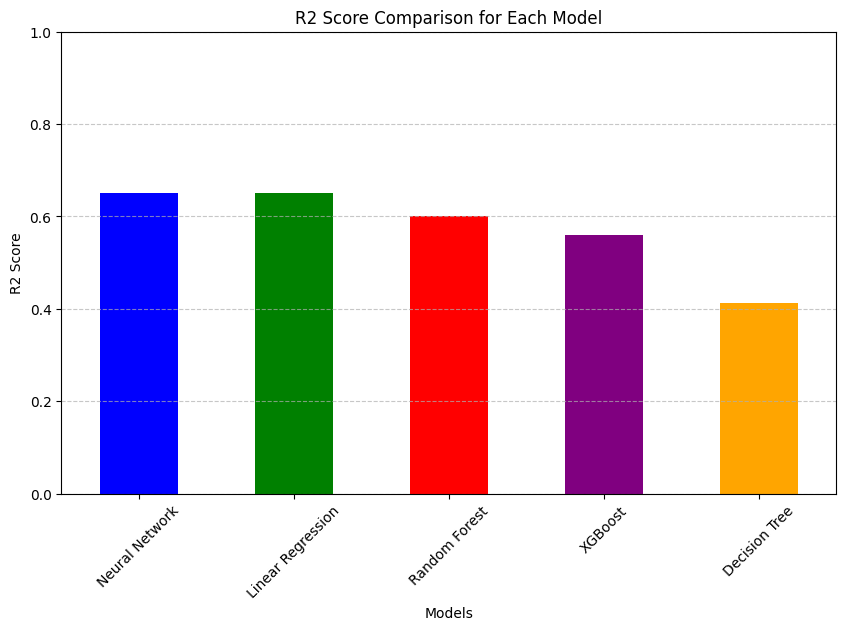

In [286]:
r2_scores = final_results_df["R2"]

plt.figure(figsize=(10, 6))
r2_scores.plot(kind="bar", color=["blue", "green", "red", "purple", "orange"])
plt.title("R2 Score Comparison for Each Model")
plt.ylabel("R2 Score")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()